check GPU (step1)
=====================
you need to change the runtime to GPU's runtime by Runtime -> Change runtime type

In [1]:
!nvidia-smi

Thu Oct  8 19:30:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


Packages (step2)
===========

In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

Auxiliary Function (step3)
========================

In [2]:
# print all attributes
def DCG_node(listValue):
    for (i, v) in enumerate(listValue):
        print(f"{i}.data: {v.data}\n{i}.requires_grad: {v.requires_grad}\n{i}.grad: {v.grad}\n{i}.grad_fn: {v.grad_fn}\n{i}.is_leaf: {v.is_leaf}\n")

Test softmax and cross-entropy
===================================

In [ ]:
loss = nn.CrossEntropyLoss()
input = torch.FloatTensor([[0.1, 0.7, 0.1, 0.1],
                          [0.2, 0.6, 0.1, 0.1],
                          [0.5, 0.2, 0.2, 0.1]])
target = torch.FloatTensor([1, 1, 0]).type(torch.long)
output = loss(input, target)
output

tensor(1.0601)

In [ ]:
loss = nn.CrossEntropyLoss()
# input = torch.randn(3, 5, requires_grad=True)
input = torch.FloatTensor([[0.1, 0.7, 0.1, 0.1, 0.1],
                          [0.2, 0.6, 0.1, 0.1, 0.1],
                          [0.5, 0.2, 0.2, 0.1, 0.1]])
target = torch.empty(3, dtype=torch.long).random_(5)
print(target)
output = loss(input, target)


tensor([1, 4, 0])


In [ ]:
print(output)

tensor(1.4175)


CNN1 (step4)
===================
The input channel is one since it is a grey picture  
We design as follow, but the output should be 10 since here are 10 unique labels

In [3]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) # 28 * 28 -> 26 * 26 
        self.conv2 = nn.Conv2d(32, 32, 3) # 26 * 26 -> 24 * 24 -> 12 * 12
        self.conv3 = nn.Conv2d(32, 64, 3) # 12 * 12 -> 10 * 10
        self.conv4 = nn.Conv2d(64, 64, 3) # 10 * 10 -> 8 * 8 -> 4 * 4 
        self.fc1   = nn.Linear(64 * 4 * 4, 3000)
        self.fc2   = nn.Linear(3000, 1000)
        self.fc3   = nn.Linear(1000, 10)
        self.softmax = nn.Softmax(dim=1)
        self.ce = nn.CrossEntropyLoss()
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        x = F.relu(self.conv1(x)) # the same as (2, 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.sigmoid(self.fc1(x))
        # x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

    # x.size(0) = y.size(0)
    def loss(self, x, y):
        loss = self.ce(x, y)
        return loss

net1 = CNN1().cuda()
print(net1)

CNN1(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
  (ce): CrossEntropyLoss()
)


In [38]:
def reshape_dataset(X):
    [d1, d3, d4] = torch.from_numpy(X).size()
    X = torch.from_numpy(X).view(d1, -1, d3, d4).type(torch.FloatTensor)
    return torch.div(X, 256)

In [39]:
X_train = reshape_dataset(X_train_numpy)[0:100, 0:1, 0:28, 0:28].cuda()
X_test = reshape_dataset(X_test_numpy).cuda()
print(f"{X_train.size()} \n {X_test.size()}") # batch size, in_channel, height, width

torch.Size([100, 1, 28, 28]) 
 torch.Size([10000, 1, 28, 28])


In [44]:
out = net1(X_train)
out.size()

torch.Size([100, 10])

CNN2
=================

In [ ]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 6) # 27 * 27 -> 22 * 22 -> 11 * 11 
        self.fc1   = nn.Linear(6 * 11 * 11, 10)
        self.softmax = nn.Softmax(dim=1)
        self.ce = nn.CrossEntropyLoss()
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) # the same as (2, 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.softmax(x)
        return x

    # x.size(0) = y.size(0)
    def loss(self, x, y):
        loss = self.ce(x, y)
        return loss

In [ ]:
net2 = CNN2()
print(net2)

CNN2(
  (conv1): Conv2d(1, 6, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features=726, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
  (ce): CrossEntropyLoss()
)


Import MNIST dataset and handle with it (step5)
=================================
import handwritten digits directly

In [4]:
from tensorflow.keras.datasets import mnist
(X_train_numpy, Y_train_numpy), (X_test_numpy, Y_test_numpy) = mnist.load_data()

In [6]:
print(f"x_train's shape is {X_train_numpy.shape}\n x_test's shape is {X_test_numpy.shape}\n \
y_train's shape is {Y_train_numpy.shape}\n y_test's shape is {Y_test_numpy.shape}")

x_train's shape is (60000, 28, 28)
 x_test's shape is (10000, 28, 28)
 y_train's shape is (60000,)
 y_test's shape is (10000,)


check the image

In [ ]:
def show_image(i):
    image = X_train_numpy[i]
    plt.imshow(image)
    plt.title(Y_train_numpy[i])
    plt.show()

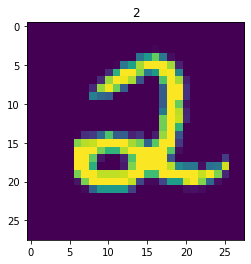

In [ ]:
show_image(29726)

check the label

In [ ]:
label = set(Y_train_numpy)
label

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

**(Do not run)convert X_trian and X_test into torch and reshape in GPU**
-----------------


In [ ]:
def reshape_dataset(X):
    [d1, d3, d4] = torch.from_numpy(X).size()
    X = torch.from_numpy(X).view(d1, -1, d3, d4).type(torch.FloatTensor)
    return torch.div(X, 256)

In [ ]:
X_train = reshape_dataset(X_train_numpy)[0:100, 0:1, 0:28, 0:28].cuda()
X_test = reshape_dataset(X_test_numpy).cuda()
print(f"{X_train.size()} \n {X_test.size()}") # batch size, in_channel, height, width

torch.Size([100, 1, 28, 28]) 
 torch.Size([10000, 1, 28, 28])


**(Do not run) convert y to torch in GPU**
---------------------------

In [ ]:
Y_train = torch.from_numpy(Y_train_numpy).type(torch.long)[0:100].cuda()
Y_test = torch.from_numpy(Y_test_numpy).type(torch.long).cuda()
print(f"{Y_train.size()} \n {Y_test.size()}")

torch.Size([100]) 
 torch.Size([10000])


In [ ]:
for t in range(3):
    X_train = reshape_dataset(X_train_numpy)[t*20000: (t+1)*20000, 0:1, 0:28, 0:28].cuda()
    Y_train = torch.from_numpy(Y_train_numpy).type(torch.long)[t*20000:(t+1)*20000].cuda()
    print(X_train.size())
    print(Y_train.size())

torch.Size([20000, 1, 28, 28])
torch.Size([20000])
torch.Size([20000, 1, 28, 28])
torch.Size([20000])
torch.Size([20000, 1, 28, 28])
torch.Size([20000])


Forward
====================

In [ ]:
out = net1(X_train)
out.size()

torch.Size([30000, 10])

In [ ]:
out[0]

tensor([0.0900, 0.0999, 0.1171, 0.0890, 0.0896, 0.1028, 0.1144, 0.1086, 0.0979,
        0.0907], device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
out.size()

torch.Size([60000, 10])

Loss function
=====================
We use cross-entropy as our loss function, this pair with softmax

In [ ]:
loss = net1.loss(out, Y_train)

In [ ]:
loss

tensor(2.3029, grad_fn=<NllLossBackward>)

Back propagation
=======================

In [ ]:
net1.zero_grad()
loss.backward()

check weights and bias

In [ ]:
DCG_node([net1.conv1.weight, net1.conv1.bias, net1.conv2.weight, 
          net1.conv2.bias, net1.fc1.weight, net1.fc1.bias,
          net1.fc2.weight, net1.fc2.bias, net1.fc3.weight,
          net1.fc3.bias])

0.data: tensor([[[[-0.1812,  0.1275, -0.1644, -0.1037],
          [ 0.0891, -0.2453, -0.0049,  0.0208],
          [ 0.1527, -0.0640,  0.1145,  0.2049],
          [-0.1695,  0.1270,  0.1877, -0.1871]]],


        [[[-0.1494, -0.0497,  0.0093, -0.2106],
          [ 0.1031, -0.2077,  0.0732,  0.0517],
          [-0.1320, -0.0500, -0.1707,  0.0752],
          [-0.0611, -0.0380,  0.0450, -0.1471]]],


        [[[-0.1556, -0.1739,  0.0063, -0.1543],
          [-0.1362, -0.1233,  0.2384, -0.0670],
          [-0.2100,  0.1638, -0.1749, -0.0352],
          [-0.0335,  0.2140, -0.1431,  0.1755]]],


        [[[ 0.0342,  0.0789, -0.0909,  0.2286],
          [ 0.2257, -0.0991, -0.1301, -0.0044],
          [-0.0696,  0.0591,  0.1882,  0.0096],
          [-0.1273, -0.0149,  0.1525,  0.1847]]],


        [[[ 0.1079, -0.0494, -0.0067,  0.0446],
          [ 0.0077,  0.0878,  0.1800,  0.0639],
          [-0.0105,  0.0399, -0.0502, -0.0392],
          [-0.0399,  0.1761, -0.0536,  0.2372]]],


        [[[ 

In [ ]:
for p in list(net1.parameters()):
    print(p.size())

torch.Size([6, 1, 4, 4])
torch.Size([6])
torch.Size([10, 6, 3, 3])
torch.Size([10])
torch.Size([100, 250])
torch.Size([100])
torch.Size([80, 100])
torch.Size([80])
torch.Size([10, 80])
torch.Size([10])


Update (**Here**) CNN1 (step6)
===================
1. change runtime to GPU (Runtime -> Change runtime type)
2. packages
3. Auxiliary function
4. CNN
5. import dataset
6. run the following code

In [5]:
from tqdm.notebook import tnrange, tqdm_notebook

In [6]:
def reshape_dataset(X):
    [d1, d3, d4] = torch.from_numpy(X).size()
    X = torch.from_numpy(X).view(d1, -1, d3, d4).type(torch.FloatTensor)
    return torch.div(X, 256)

in 0/0: loss is 2.302605390548706, accu is 0.0955
in 100/0: loss is 2.3024392127990723, accu is 0.1285
in 200/0: loss is 2.3022773265838623, accu is 0.107
in 300/0: loss is 2.302112579345703, accu is 0.2065
in 400/0: loss is 2.3019325733184814, accu is 0.123
in 500/0: loss is 2.3017215728759766, accu is 0.112
in 600/0: loss is 2.3014490604400635, accu is 0.112
in 700/0: loss is 2.3010661602020264, accu is 0.112
in 800/0: loss is 2.3004519939422607, accu is 0.1125
in 900/0: loss is 2.299189567565918, accu is 0.142



in 0/1: loss is 2.2950329780578613, accu is 0.224
in 100/1: loss is 1.9823780059814453, accu is 0.506
in 200/1: loss is 1.6559056043624878, accu is 0.814
in 300/1: loss is 1.5301570892333984, accu is 0.941
in 400/1: loss is 1.5186994075775146, accu is 0.9485
in 500/1: loss is 1.4945189952850342, accu is 0.969
in 600/1: loss is 1.4796116352081299, accu is 0.9825
in 700/1: loss is 1.4787189960479736, accu is 0.983
in 800/1: loss is 1.4784367084503174, accu is 0.983
in 900/1: loss is 1.4775514602661133, accu is 0.984



in 0/2: loss is 1.5422216653823853, accu is 0.919
in 100/2: loss is 1.491736888885498, accu is 0.972
in 200/2: loss is 1.482155442237854, accu is 0.98
in 300/2: loss is 1.480949878692627, accu is 0.9805
in 400/2: loss is 1.4794148206710815, accu is 0.982
in 500/2: loss is 1.4783604145050049, accu is 0.983
in 600/2: loss is 1.4782514572143555, accu is 0.983
in 700/2: loss is 1.4781970977783203, accu is 0.983
in 800/2: loss is 1.4781626462936401, accu is 0.983
in 900/2: loss is 1.4777140617370605, accu is 0.9835



in 0/3: loss is 1.5199437141418457, accu is 0.9415
in 100/3: loss is 1.5026243925094604, accu is 0.9605
in 200/3: loss is 1.4800095558166504, accu is 0.9815
in 300/3: loss is 1.4793323278427124, accu is 0.982
in 400/3: loss is 1.479213833808899, accu is 0.982
in 500/3: loss is 1.4777367115020752, accu is 0.9835
in 600/3: loss is 1.4772019386291504, accu is 0.984
in 700/3: loss is 1.4771476984024048, accu is 0.984
in 800/3: loss is 1.4771205186843872, accu is 0.984
in 900/3: loss is 1.4771028757095337, accu is 0.984



in 0/4: loss is 1.5194926261901855, accu is 0.9445
in 100/4: loss is 1.4820303916931152, accu is 0.9795
in 200/4: loss is 1.481170892715454, accu is 0.98
in 300/4: loss is 1.4798704385757446, accu is 0.9815
in 400/4: loss is 1.4790335893630981, accu is 0.982
in 500/4: loss is 1.4780606031417847, accu is 0.983
in 600/4: loss is 1.4775160551071167, accu is 0.9835
in 700/4: loss is 1.4774733781814575, accu is 0.9835
in 800/4: loss is 1.477454423904419, accu is 0.9835
in 900/4: loss is 1.477440357208252, accu is 0.9835



in 0/5: loss is 1.507367730140686, accu is 0.9535
in 100/5: loss is 1.4766685962677002, accu is 0.985
in 200/5: loss is 1.4747979640960693, accu is 0.9865
in 300/5: loss is 1.4737894535064697, accu is 0.9875
in 400/5: loss is 1.4737284183502197, accu is 0.9875
in 500/5: loss is 1.4732171297073364, accu is 0.988
in 600/5: loss is 1.4731907844543457, accu is 0.988
in 700/5: loss is 1.4727058410644531, accu is 0.9885
in 800/5: loss is 1.4721910953521729, accu is 0.989
in 900/5: loss is 1.4721728563308716, accu is 0.989



in 0/6: loss is 1.5072511434555054, accu is 0.9555
in 100/6: loss is 1.4773962497711182, accu is 0.984
in 200/6: loss is 1.4767184257507324, accu is 0.9845
in 300/6: loss is 1.476653814315796, accu is 0.9845
in 400/6: loss is 1.476623296737671, accu is 0.9845
in 500/6: loss is 1.4766052961349487, accu is 0.9845
in 600/6: loss is 1.4765938520431519, accu is 0.9845
in 700/6: loss is 1.4765857458114624, accu is 0.9845
in 800/6: loss is 1.476579189300537, accu is 0.9845
in 900/6: loss is 1.4765738248825073, accu is 0.9845



in 0/7: loss is 1.5111266374588013, accu is 0.9515
in 100/7: loss is 1.4758371114730835, accu is 0.9855
in 200/7: loss is 1.4756743907928467, accu is 0.9855
in 300/7: loss is 1.4756301641464233, accu is 0.9855
in 400/7: loss is 1.4756075143814087, accu is 0.9855
in 500/7: loss is 1.4755851030349731, accu is 0.9855
in 600/7: loss is 1.4731980562210083, accu is 0.988
in 700/7: loss is 1.4730942249298096, accu is 0.988
in 800/7: loss is 1.4730807542800903, accu is 0.988
in 900/7: loss is 1.4730558395385742, accu is 0.988



in 0/8: loss is 1.5032939910888672, accu is 0.96
in 100/8: loss is 1.4752633571624756, accu is 0.986
in 200/8: loss is 1.4751155376434326, accu is 0.986
in 300/8: loss is 1.4750815629959106, accu is 0.986
in 400/8: loss is 1.4750640392303467, accu is 0.986
in 500/8: loss is 1.4750522375106812, accu is 0.986
in 600/8: loss is 1.4745728969573975, accu is 0.9865
in 700/8: loss is 1.4740710258483887, accu is 0.987
in 800/8: loss is 1.4740614891052246, accu is 0.987
in 900/8: loss is 1.4740560054779053, accu is 0.987



in 0/9: loss is 1.493858814239502, accu is 0.967
in 100/9: loss is 1.4707735776901245, accu is 0.9905
in 200/9: loss is 1.4706672430038452, accu is 0.9905
in 300/9: loss is 1.4706345796585083, accu is 0.9905
in 400/9: loss is 1.4701650142669678, accu is 0.991
in 500/9: loss is 1.4701529741287231, accu is 0.991
in 600/9: loss is 1.4701464176177979, accu is 0.991
in 700/9: loss is 1.4701417684555054, accu is 0.991
in 800/9: loss is 1.4701385498046875, accu is 0.991
in 900/9: loss is 1.4701358079910278, accu is 0.991



in 0/10: loss is 1.494655728340149, accu is 0.966
in 100/10: loss is 1.4760076999664307, accu is 0.985
in 200/10: loss is 1.4749476909637451, accu is 0.986
in 300/10: loss is 1.4749250411987305, accu is 0.986
in 400/10: loss is 1.4749152660369873, accu is 0.986
in 500/10: loss is 1.4749078750610352, accu is 0.986
in 600/10: loss is 1.4744391441345215, accu is 0.9865
in 700/10: loss is 1.473935842514038, accu is 0.987
in 800/10: loss is 1.473926305770874, accu is 0.987
in 900/10: loss is 1.4739216566085815, accu is 0.987



in 0/11: loss is 1.499506950378418, accu is 0.9615
in 100/11: loss is 1.471212387084961, accu is 0.99
in 200/11: loss is 1.47060227394104, accu is 0.9905
in 300/11: loss is 1.4705796241760254, accu is 0.9905
in 400/11: loss is 1.4701489210128784, accu is 0.991
in 500/11: loss is 1.4696139097213745, accu is 0.9915
in 600/11: loss is 1.469605803489685, accu is 0.9915
in 700/11: loss is 1.4696016311645508, accu is 0.9915
in 800/11: loss is 1.4695985317230225, accu is 0.9915
in 900/11: loss is 1.4695963859558105, accu is 0.9915



in 0/12: loss is 1.499998927116394, accu is 0.9615
in 100/12: loss is 1.4756484031677246, accu is 0.9855
in 200/12: loss is 1.475609540939331, accu is 0.9855
in 300/12: loss is 1.4755953550338745, accu is 0.9855
in 400/12: loss is 1.4746968746185303, accu is 0.9865
in 500/12: loss is 1.4745965003967285, accu is 0.9865
in 600/12: loss is 1.474582314491272, accu is 0.9865
in 700/12: loss is 1.4736146926879883, accu is 0.9875
in 800/12: loss is 1.4721499681472778, accu is 0.989
in 900/12: loss is 1.4721252918243408, accu is 0.989



in 0/13: loss is 1.5034432411193848, accu is 0.957
in 100/13: loss is 1.4732729196548462, accu is 0.988
in 200/13: loss is 1.4721304178237915, accu is 0.989
in 300/13: loss is 1.471598505973816, accu is 0.9895
in 400/13: loss is 1.4711151123046875, accu is 0.99
in 500/13: loss is 1.4711058139801025, accu is 0.99
in 600/13: loss is 1.470625877380371, accu is 0.9905
in 700/13: loss is 1.470619797706604, accu is 0.9905
in 800/13: loss is 1.4706162214279175, accu is 0.9905
in 900/13: loss is 1.4706135988235474, accu is 0.9905



in 0/14: loss is 1.499272108078003, accu is 0.9615
in 100/14: loss is 1.470683217048645, accu is 0.9905
in 200/14: loss is 1.470170259475708, accu is 0.991
in 300/14: loss is 1.470118522644043, accu is 0.991
in 400/14: loss is 1.4696016311645508, accu is 0.9915
in 500/14: loss is 1.4691252708435059, accu is 0.992
in 600/14: loss is 1.4691107273101807, accu is 0.992
in 700/14: loss is 1.4689741134643555, accu is 0.992
in 800/14: loss is 1.4685908555984497, accu is 0.9925
in 900/14: loss is 1.4681074619293213, accu is 0.993



in 0/15: loss is 1.4984266757965088, accu is 0.965
in 100/15: loss is 1.4736043214797974, accu is 0.9875
in 200/15: loss is 1.473060131072998, accu is 0.988
in 300/15: loss is 1.4727513790130615, accu is 0.9885
in 400/15: loss is 1.4720607995986938, accu is 0.989
in 500/15: loss is 1.4720462560653687, accu is 0.989
in 600/15: loss is 1.4720381498336792, accu is 0.989
in 700/15: loss is 1.4719942808151245, accu is 0.989
in 800/15: loss is 1.471972942352295, accu is 0.989
in 900/15: loss is 1.471969485282898, accu is 0.989



in 0/16: loss is 1.4877748489379883, accu is 0.9745
in 100/16: loss is 1.469233751296997, accu is 0.992
in 200/16: loss is 1.4686373472213745, accu is 0.9925
in 300/16: loss is 1.4681309461593628, accu is 0.993
in 400/16: loss is 1.4681211709976196, accu is 0.993
in 500/16: loss is 1.468116283416748, accu is 0.993
in 600/16: loss is 1.4681130647659302, accu is 0.993
in 700/16: loss is 1.4681106805801392, accu is 0.993
in 800/16: loss is 1.468109130859375, accu is 0.993
in 900/16: loss is 1.4681075811386108, accu is 0.993



in 0/17: loss is 1.4940986633300781, accu is 0.968
in 100/17: loss is 1.4696799516677856, accu is 0.9915
in 200/17: loss is 1.469612956047058, accu is 0.9915
in 300/17: loss is 1.469600796699524, accu is 0.9915
in 400/17: loss is 1.469594120979309, accu is 0.9915
in 500/17: loss is 1.4695879220962524, accu is 0.9915
in 600/17: loss is 1.4695814847946167, accu is 0.9915
in 700/17: loss is 1.469089150428772, accu is 0.992
in 800/17: loss is 1.469083547592163, accu is 0.992
in 900/17: loss is 1.4690800905227661, accu is 0.992



in 0/18: loss is 1.4938135147094727, accu is 0.967
in 100/18: loss is 1.4776370525360107, accu is 0.9835
in 200/18: loss is 1.4760874509811401, accu is 0.985
in 300/18: loss is 1.4755854606628418, accu is 0.9855
in 400/18: loss is 1.4755613803863525, accu is 0.9855
in 500/18: loss is 1.4755573272705078, accu is 0.9855
in 600/18: loss is 1.4755547046661377, accu is 0.9855
in 700/18: loss is 1.4755522012710571, accu is 0.9855
in 800/18: loss is 1.4750548601150513, accu is 0.986
in 900/18: loss is 1.4750518798828125, accu is 0.986



in 0/19: loss is 1.4932303428649902, accu is 0.9685
in 100/19: loss is 1.4722180366516113, accu is 0.989
in 200/19: loss is 1.4721465110778809, accu is 0.989
in 300/19: loss is 1.47213613986969, accu is 0.989
in 400/19: loss is 1.4721304178237915, accu is 0.989
in 500/19: loss is 1.4716187715530396, accu is 0.9895
in 600/19: loss is 1.4716107845306396, accu is 0.9895
in 700/19: loss is 1.4716081619262695, accu is 0.9895
in 800/19: loss is 1.4716063737869263, accu is 0.9895
in 900/19: loss is 1.4716051816940308, accu is 0.9895



in 0/20: loss is 1.4923394918441772, accu is 0.9685
in 100/20: loss is 1.4726423025131226, accu is 0.9885
in 200/20: loss is 1.472109317779541, accu is 0.989
in 300/20: loss is 1.4715670347213745, accu is 0.9895
in 400/20: loss is 1.4715576171875, accu is 0.9895
in 500/20: loss is 1.4715529680252075, accu is 0.9895
in 600/20: loss is 1.4715461730957031, accu is 0.9895
in 700/20: loss is 1.4710462093353271, accu is 0.99
in 800/20: loss is 1.4710432291030884, accu is 0.99
in 900/20: loss is 1.4710242748260498, accu is 0.99



in 0/21: loss is 1.495115041732788, accu is 0.9655
in 100/21: loss is 1.4725953340530396, accu is 0.9885
in 200/21: loss is 1.4725711345672607, accu is 0.9885
in 300/21: loss is 1.4720661640167236, accu is 0.989
in 400/21: loss is 1.472057819366455, accu is 0.989
in 500/21: loss is 1.4720385074615479, accu is 0.989
in 600/21: loss is 1.4720358848571777, accu is 0.989
in 700/21: loss is 1.472033977508545, accu is 0.989
in 800/21: loss is 1.472030758857727, accu is 0.989
in 900/21: loss is 1.472014307975769, accu is 0.989



in 0/22: loss is 1.4968605041503906, accu is 0.964
in 100/22: loss is 1.4731642007827759, accu is 0.988
in 200/22: loss is 1.4731024503707886, accu is 0.988
in 300/22: loss is 1.4726229906082153, accu is 0.9885
in 400/22: loss is 1.4726167917251587, accu is 0.9885
in 500/22: loss is 1.4726130962371826, accu is 0.9885
in 600/22: loss is 1.4726089239120483, accu is 0.9885
in 700/22: loss is 1.4721122980117798, accu is 0.989
in 800/22: loss is 1.4721091985702515, accu is 0.989
in 900/22: loss is 1.472108006477356, accu is 0.989



in 0/23: loss is 1.4986279010772705, accu is 0.9625
in 100/23: loss is 1.475656270980835, accu is 0.9855
in 200/23: loss is 1.4746288061141968, accu is 0.9865
in 300/23: loss is 1.4741253852844238, accu is 0.987
in 400/23: loss is 1.4726365804672241, accu is 0.9885
in 500/23: loss is 1.47220778465271, accu is 0.989
in 600/23: loss is 1.4721366167068481, accu is 0.989
in 700/23: loss is 1.4721318483352661, accu is 0.989
in 800/23: loss is 1.472128987312317, accu is 0.989
in 900/23: loss is 1.472127079963684, accu is 0.989



in 0/24: loss is 1.5012767314910889, accu is 0.9595
in 100/24: loss is 1.4686616659164429, accu is 0.9925
in 200/24: loss is 1.4681477546691895, accu is 0.993
in 300/24: loss is 1.4681364297866821, accu is 0.993
in 400/24: loss is 1.4681317806243896, accu is 0.993
in 500/24: loss is 1.46812903881073, accu is 0.993
in 600/24: loss is 1.4676331281661987, accu is 0.9935
in 700/24: loss is 1.4676276445388794, accu is 0.9935
in 800/24: loss is 1.4676257371902466, accu is 0.9935
in 900/24: loss is 1.4676247835159302, accu is 0.9935



in 0/25: loss is 1.486232876777649, accu is 0.9745
in 100/25: loss is 1.4721664190292358, accu is 0.989
in 200/25: loss is 1.4711657762527466, accu is 0.99
in 300/25: loss is 1.4708967208862305, accu is 0.9905
in 400/25: loss is 1.469705581665039, accu is 0.9915
in 500/25: loss is 1.4696520566940308, accu is 0.9915
in 600/25: loss is 1.4696476459503174, accu is 0.9915
in 700/25: loss is 1.4696452617645264, accu is 0.9915
in 800/25: loss is 1.4696438312530518, accu is 0.9915
in 900/25: loss is 1.469642162322998, accu is 0.9915



in 0/26: loss is 1.4949361085891724, accu is 0.9685
in 100/26: loss is 1.4785550832748413, accu is 0.9825
in 200/26: loss is 1.4761080741882324, accu is 0.985
in 300/26: loss is 1.4760559797286987, accu is 0.985
in 400/26: loss is 1.4750537872314453, accu is 0.986
in 500/26: loss is 1.4740769863128662, accu is 0.987
in 600/26: loss is 1.4735562801361084, accu is 0.9875
in 700/26: loss is 1.4735310077667236, accu is 0.9875
in 800/26: loss is 1.4735275506973267, accu is 0.9875
in 900/26: loss is 1.4730279445648193, accu is 0.988



in 0/27: loss is 1.491775393486023, accu is 0.968
in 100/27: loss is 1.4703257083892822, accu is 0.991
in 200/27: loss is 1.4690821170806885, accu is 0.992
in 300/27: loss is 1.4690725803375244, accu is 0.992
in 400/27: loss is 1.4690684080123901, accu is 0.992
in 500/27: loss is 1.4690660238265991, accu is 0.992
in 600/27: loss is 1.4690643548965454, accu is 0.992
in 700/27: loss is 1.468578815460205, accu is 0.9925
in 800/27: loss is 1.4685662984848022, accu is 0.9925
in 900/27: loss is 1.4685614109039307, accu is 0.9925



in 0/28: loss is 1.485106348991394, accu is 0.9765
in 100/28: loss is 1.4685994386672974, accu is 0.9925
in 200/28: loss is 1.4680694341659546, accu is 0.993
in 300/28: loss is 1.4675867557525635, accu is 0.9935
in 400/28: loss is 1.4675651788711548, accu is 0.9935
in 500/28: loss is 1.4675624370574951, accu is 0.9935
in 600/28: loss is 1.467560887336731, accu is 0.9935
in 700/28: loss is 1.46755850315094, accu is 0.9935
in 800/28: loss is 1.4670618772506714, accu is 0.994
in 900/28: loss is 1.467059850692749, accu is 0.994



in 0/29: loss is 1.4783697128295898, accu is 0.9835
in 100/29: loss is 1.4681521654129028, accu is 0.993
in 200/29: loss is 1.4670977592468262, accu is 0.994
in 300/29: loss is 1.4670920372009277, accu is 0.994
in 400/29: loss is 1.467085361480713, accu is 0.994
in 500/29: loss is 1.4670839309692383, accu is 0.994
in 600/29: loss is 1.467083215713501, accu is 0.994
in 700/29: loss is 1.4670827388763428, accu is 0.994
in 800/29: loss is 1.4670822620391846, accu is 0.994
in 900/29: loss is 1.4670820236206055, accu is 0.994



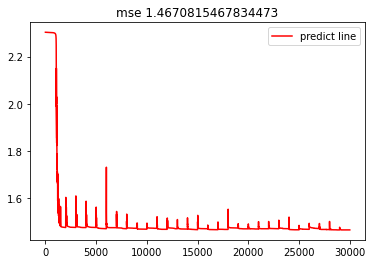

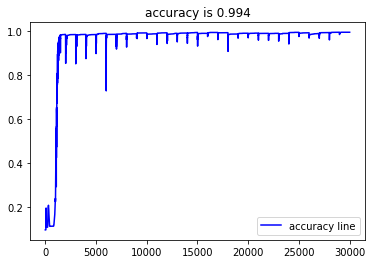

In [7]:
optimizer = optim.SGD(net1.parameters(), lr=0.1)
epochs = 1000
interval = 2000
epoch_list = []
loss_list = []
correct_list = []

for t in range(30):
    X_train = reshape_dataset(X_train_numpy)[t*interval: (t+1)*interval, 0:1, 0:28, 0:28].cuda()
    Y_train = torch.from_numpy(Y_train_numpy).type(torch.long)[t*interval:(t+1)*interval].cuda()
    for epoch in tnrange(epochs, desc='epoch'):
        optimizer.zero_grad()
        out = net1(X_train)
        loss = net1.loss(out, Y_train)
        loss.backward()
        optimizer.step()    # Does the update
        epoch_list.append(epoch + t * epochs)
        loss_list.append(loss.item())

        # accuracy
        pred = out.data.max(1, keepdim=False)[1]
        correct = pred.eq(Y_train.data.view_as(pred)).cpu().detach().sum()
        correct_rate = correct.detach().item() / interval
        correct_list.append(correct_rate)

        if(epoch % 100 == 0):
            print(f"in {epoch}/{t}: loss is {loss}, accu is {correct_rate}")

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=loss_list, color='red', label='predict line', ax=ax)
plt.title(f"mse {loss}")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=correct_list, color='blue', label='accuracy line', ax=ax)
plt.title(f"accuracy is {correct_rate}")
plt.show()

storage
----------------

In [9]:
path = '/content/drive/My Drive/Colab Notebooks/AI_relative/algorithm_explore/pretrained_model/CNN_MNIST_model.pt'
torch.save(net1.state_dict(), path)

reload
--------------------

In [10]:
import torch

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/AI_relative/algorithm_explore/pretrained_model/CNN_MNIST_model.pt'

net1.load_state_dict(torch.load(path))
net1.eval()

CNN1(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
  (ce): CrossEntropyLoss()
)

check
---------------------

In [ ]:
from tensorflow.keras.datasets import mnist
(X_train_numpy, Y_train_numpy), (X_test_numpy, Y_test_numpy) = mnist.load_data()

In [ ]:
def reshape_dataset(X):
    [d1, d3, d4] = torch.from_numpy(X).size()
    X = torch.from_numpy(X).view(d1, -1, d3, d4).type(torch.FloatTensor)
    return torch.div(X, 256)

In [ ]:
X_train = reshape_dataset(X_train_numpy)[0:100, 0:1, 0:28, 0:28].cuda()
X_test = reshape_dataset(X_test_numpy).cuda()
print(f"{X_train.size()} \n {X_test.size()}") # batch size, in_channel, height

torch.Size([100, 1, 28, 28]) 
 torch.Size([10000, 1, 28, 28])


In [ ]:
Y_train = torch.from_numpy(Y_train_numpy).type(torch.long)[0:100].cuda()
Y_test = torch.from_numpy(Y_test_numpy).type(torch.long).cuda()
print(f"{Y_train.size()} \n {Y_test.size()}")

torch.Size([100]) 
 torch.Size([10000])


In [ ]:
out = net1(X_train)
out.size()

torch.Size([100, 10])

In [ ]:
pred = out.data.max(1, keepdim=False)[1]
correct = pred.eq(Y_train.data.view_as(pred)).cpu().detach().sum()
correct_rate = correct.detach().item() / 100
correct_rate

0.94

***Update (Here) CNN2***
==============================

In [ ]:
optimizer = optim.SGD(net2.parameters(), lr=0.01)
epochs = 3000
epoch_list = []
loss_list = []
fig, ax = plt.subplots()
lr = 0.01

for epoch in tnrange(epochs, desc='epoch'):
    optimizer.zero_grad()
    out = net2(X_train)
    loss = net2.loss(out, Y_train)
    loss.backward()
    optimizer.step()    # Does the update
    # net1.conv1.weight.data = (net1.conv1.weight.data - lr * net1.conv1.weight.grad).detach()
    # net1.conv1.bias.data = (net1.conv1.bias.data - lr * net1.conv1.bias.grad).detach()
    # net1.conv2.weight.data = (net1.conv2.weight.data - lr * net1.conv2.weight.grad).detach()
    # net1.conv2.bias.data = (net1.conv2.bias.data - lr * net1.conv2.bias.grad).detach()
    # net1.fc1.weight.data = (net1.fc1.weight.data - lr * net1.fc1.weight.grad).detach()
    # net1.fc1.bias.data = (net1.fc1.bias.data - lr * net1.fc1.bias.grad).detach()
    # net1.fc2.weight.data = (net1.fc2.weight.data - lr * net1.fc2.weight.grad).detach()
    # net1.fc2.bias.data = (net1.fc2.bias.data - lr * net1.fc2.bias.grad).detach()
    epoch_list.append(epoch)
    loss_list.append(loss.item())
    if(epoch % 100 == 0):
        print(f"in {epoch}: {loss}")

sns.lineplot(x=epoch_list, y=loss_list, color='red', label='predict line', ax=ax)
plt.title(f"mse {loss}")

in 0: 1.8229023218154907
in 100: 1.7807170152664185
in 200: 1.7333829402923584
in 300: 1.692622423171997
in 400: 1.671080231666565
in 500: 1.6565799713134766


Please check the out although the loss is not awesome
======================
use numpy argmax to find the index of the max value

In [1]:
import numpy as np

In [12]:
pred = out.data.max(1, keepdim=False)[1]
pred

tensor([7, 7, 0,  ..., 3, 6, 8], device='cuda:0')

In [13]:
correct = pred.eq(Y_train.data.view_as(pred)).cpu().detach().sum()
correct

tensor(18031)

In [14]:
correct_rate = correct.detach().item() /20000
correct_rate

0.90155

In [15]:
miss = 0
train_pred = out.cpu().detach().numpy()
train_real = Y_train.cpu().detach().numpy()
max_index = np.argmax(train_pred, 1)
for i, (a, b) in enumerate(zip(max_index, train_real)):
    if a == b: signal = 'v'
    if a != b: 
        signal = 'x'
        miss += 1
    print(f"{i}: {a}, {b}, {train_pred[i, a]} => {signal}")
print(f"miss is {miss}")

Streaming output truncated to the last 5000 lines.
15002: 8, 8, 1.0 => v
15003: 7, 7, 1.0 => v
15004: 4, 4, 1.0 => v
15005: 4, 4, 0.9999998807907104 => v
15006: 0, 0, 1.0 => v
15007: 9, 9, 0.9999998807907104 => v
15008: 3, 3, 1.0 => v
15009: 9, 9, 0.9999998807907104 => v
15010: 8, 5, 0.645573079586029 => x
15011: 2, 2, 0.999995231628418 => v
15012: 6, 6, 1.0 => v
15013: 9, 9, 1.0 => v
15014: 1, 1, 0.9999998807907104 => v
15015: 8, 8, 0.9734538197517395 => v
15016: 6, 6, 1.0 => v
15017: 3, 3, 1.0 => v
15018: 6, 6, 0.9999945163726807 => v
15019: 6, 6, 0.9999904632568359 => v
15020: 8, 8, 1.0 => v
15021: 7, 7, 0.9994810223579407 => v
15022: 8, 8, 0.9978717565536499 => v
15023: 0, 0, 1.0 => v
15024: 4, 4, 1.0 => v
15025: 4, 4, 0.9999992847442627 => v
15026: 8, 8, 0.9999995231628418 => v
15027: 0, 0, 0.9999998807907104 => v
15028: 3, 3, 0.9749846458435059 => v
15029: 0, 0, 1.0 => v
15030: 0, 0, 0.999992847442627 => v
15031: 1, 1, 1.0 => v
15032: 2, 2, 1.0 => v
15033: 2, 2, 1.0 => v
15034: 7

In [ ]:
print(train_pred[0:1])
print(train_real[0:1])

tensor([[0.0917, 0.0836, 0.1006, 0.0983, 0.0904, 0.1133, 0.1051, 0.0931, 0.1109,
         0.1129]], grad_fn=<SliceBackward>)
tensor([5])
